In [412]:
import cv2
import os
import re
import numpy as np
import tifffile
from matplotlib import pyplot as plt
from scipy import ndimage
from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull

In [365]:
#setup variables
color_channel = 1 #1,2,3

var_kernel_row = 1 #1 was good
var_kernel_col = 1 #1 was good
cstacks_blur_kernel = (9,9) #was using 3,3 before with ok results. 7,7 seems to blend away the halo a bit
pixel_offset = 1 #don't need an offset anymore since figuring out the float problem
blur_sd = 5 #3was good so was 1, maybe 1 best, went to 5 with a 5,5 blur kernel and saw no diff.

In [366]:
# 20210119-015407_FF_20X_LATE_JLV_TOP_00012_W

path = "/Users/wesleywong/single-field-zstack copy merge/20X_CD451_CC3_3X5_STD/" #i need this
fins = "/Users/wesleywong/single-field-zstack copy merge/20X_CD451_CC3_3X5_STD/" #and this
fins = os.listdir(fins)

only_tifs = re.compile(r'.*CH.[.]tif')

#find all the z-positions
zpos = re.compile(r'Z\d\d\d')


In [367]:
all_tifs = []
for file in fins:
    if re.match(only_tifs,file):
        all_tifs.append(file)
    

In [368]:
print(all_tifs[0:3])

['20X_LATE_JLV_TOP_00007_Z053_CH2.tif', '20X_LATE_JLV_TOP_00010_Z025_CH4.tif', '20X_LATE_JLV_TOP_00014_Z042_CH1.tif']


In [369]:
unique_z_pos = []
for file in all_tifs:
    unique_z_pos.append(re.search(zpos,file).group(0))

In [370]:
unique_z_pos = sorted(unique_z_pos)
unique_z_pos = np.unique(unique_z_pos).tolist()
print(unique_z_pos[0:3])

['Z001', 'Z002', 'Z003']


In [371]:
test = all_tifs[0]
print(test)

20X_LATE_JLV_TOP_00007_Z053_CH2.tif


In [372]:
image_family_name = re.compile(r'^.*\d\d\d\d\d_Z')
base_name = re.search(image_family_name, all_tifs[0]).group(0)[:-7] #without tile or z pos
print('image series root name: %s' %base_name)

image series root name: 20X_LATE_JLV_TOP_


In [373]:
image_stack = []
ch = str(color_channel) #(1-4)
for z in unique_z_pos:
    image_stack.append(str(base_name+'00001_'+z+'_CH'+ch+'.tif'))

In [374]:
print(image_stack[0:3])

['20X_LATE_JLV_TOP_00001_Z001_CH1.tif', '20X_LATE_JLV_TOP_00001_Z002_CH1.tif', '20X_LATE_JLV_TOP_00001_Z003_CH1.tif']


In [375]:
image_stack_arrays = []
for image in image_stack:
    fullpath = path+image
    im = tifffile.imread(fullpath)
    try: 
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    except: 
        im = im
    image_stack_arrays.append(im)

In [376]:
print('stack length: %d' % len(image_stack_arrays)) #image_stack_arrays is what I should try to apply the MCI functions to

stack length: 82


# start contrast calcs

In [377]:
#FIRST PIECE OF THE PUZZLE i think the whole thing is correct
def calcContrast(image, w_x, w_y):
    image = image.astype('float')
    kernel_fill = 1/((2*w_x+2)*(2*w_y+2))
    kernel_row = np.array([kernel_fill for x in range(0,2*w_y+2)]) #this is definitely correct
    kernel = np.array([kernel_row for x in range(0,2*w_x+2)]) #this is definitely correct
    
    img_squared = np.square(image.astype('float'))
    print('img_squared: %s' % img_squared.dtype)
    
    contrast = cv2.filter2D(img_squared, -1, kernel) - np.square(cv2.filter2D(image, -1, kernel)) #neg value means result array same data depth as source

    return contrast

In [431]:
foo = calcContrast(image_stack_arrays[0],var_kernel_row,var_kernel_col)
print(foo.shape)
print(foo.dtype)

if np.max(foo)==0:
    print('max value of mask is %d (NOT GOOD)' % np.max(foo))
else:
    print('maybe it worked')

img_squared: float64
(720, 960)
float64
maybe it worked


original:  uint8
contrast:  float64


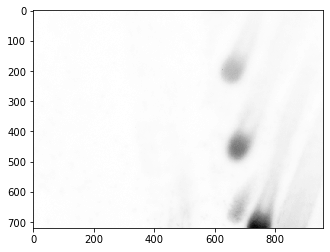

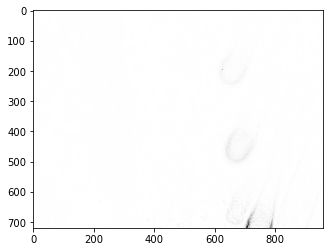

In [432]:
from matplotlib import pyplot as plt

plt.figure(1)
print('original: ',image_stack_arrays[0].dtype)
plt.imshow(image_stack_arrays[0],cmap='Greys')
plt.figure(2)
print('contrast: ',foo.dtype)
plt.imshow(foo,cmap='Greys')

Text(0.5, 1.0, 'z=80')

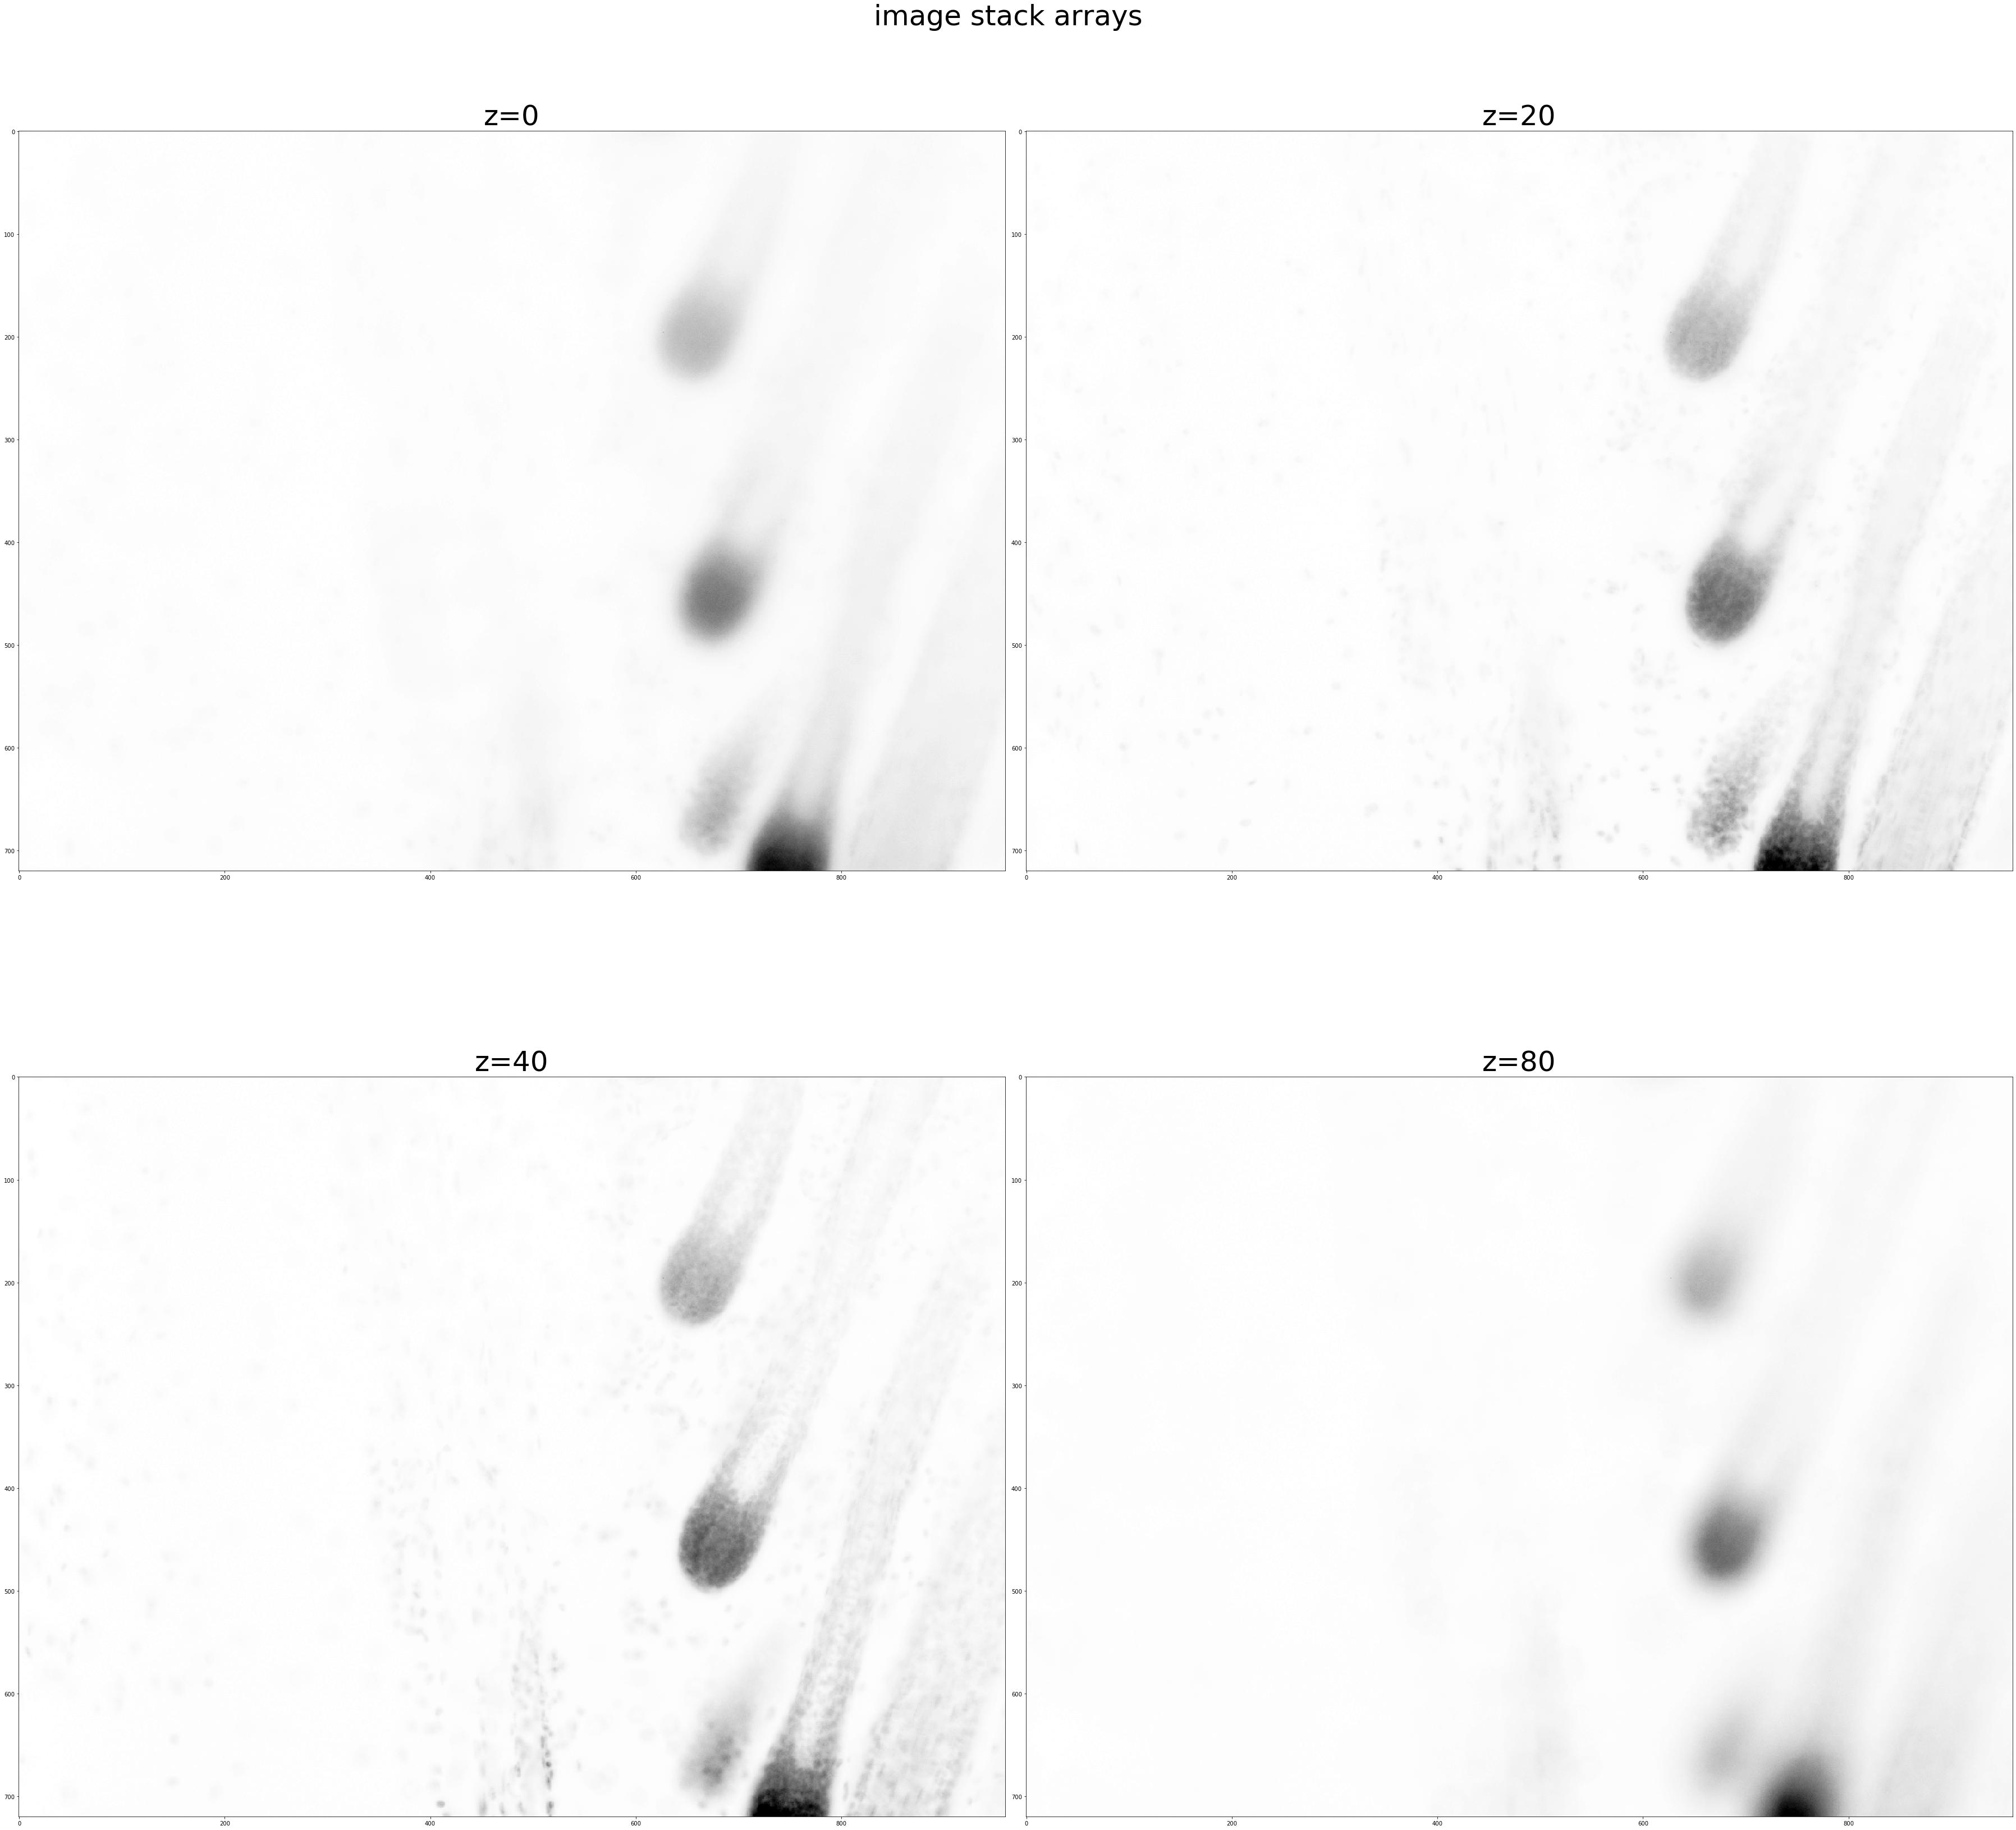

In [433]:
fig = plt.figure(figsize=(50,50))
fig.set_tight_layout(True)
fig.suptitle('image stack arrays',fontsize=50)

ax = fig.add_subplot(2,2,1)
ax.imshow(image_stack_arrays[0],cmap='Greys')
ax.set_title('z=0',fontsize=50)
ax = fig.add_subplot(2,2,2)
ax.imshow(image_stack_arrays[20],cmap='Greys')
ax.set_title('z=20',fontsize=50)
ax = fig.add_subplot(2,2,3)
ax.imshow(image_stack_arrays[40],cmap='Greys')
ax.set_title('z=40',fontsize=50)
ax = fig.add_subplot(2,2,4)
ax.imshow(image_stack_arrays[80],cmap='Greys')
ax.set_title('z=80',fontsize=50)

In [434]:
def getContrastStack(imageStack, w_x, w_y):
    # Calculate the contrast for each image in the stack
    temp_stack = []
    #contrast_stack = lapply(img_frames, calcContrast, w_x, w_y, brushShape)
    for frame in imageStack:
        temp=calcContrast(frame, w_x, w_y)
        temp_stack.append(temp) #i just needed to combine the 3 layers somehow...
    #contrast_stack = np.dstack(temp_stack)
    contrast_stack = temp_stack
    return contrast_stack #single channel MCP

In [435]:
cstacks = getContrastStack(image_stack_arrays, var_kernel_row, var_kernel_col)
print(cstacks[0].dtype)

img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: 

In [436]:
########comment out if shit breaks

f_cstacks = []
for each_cstack in cstacks:
    foo = np.array(list(map(lambda x: x < np.max(x)*pixel_offset,each_cstack)))
    blurred = cv2.GaussianBlur(foo*each_cstack,cstacks_blur_kernel,sigmaX=blur_sd)
    f_cstacks.append(blurred)
    
cstacks = f_cstacks
print(cstacks[0].dtype)

float64


(720, 960) 82


Text(0.5, 1.0, 'z=80')

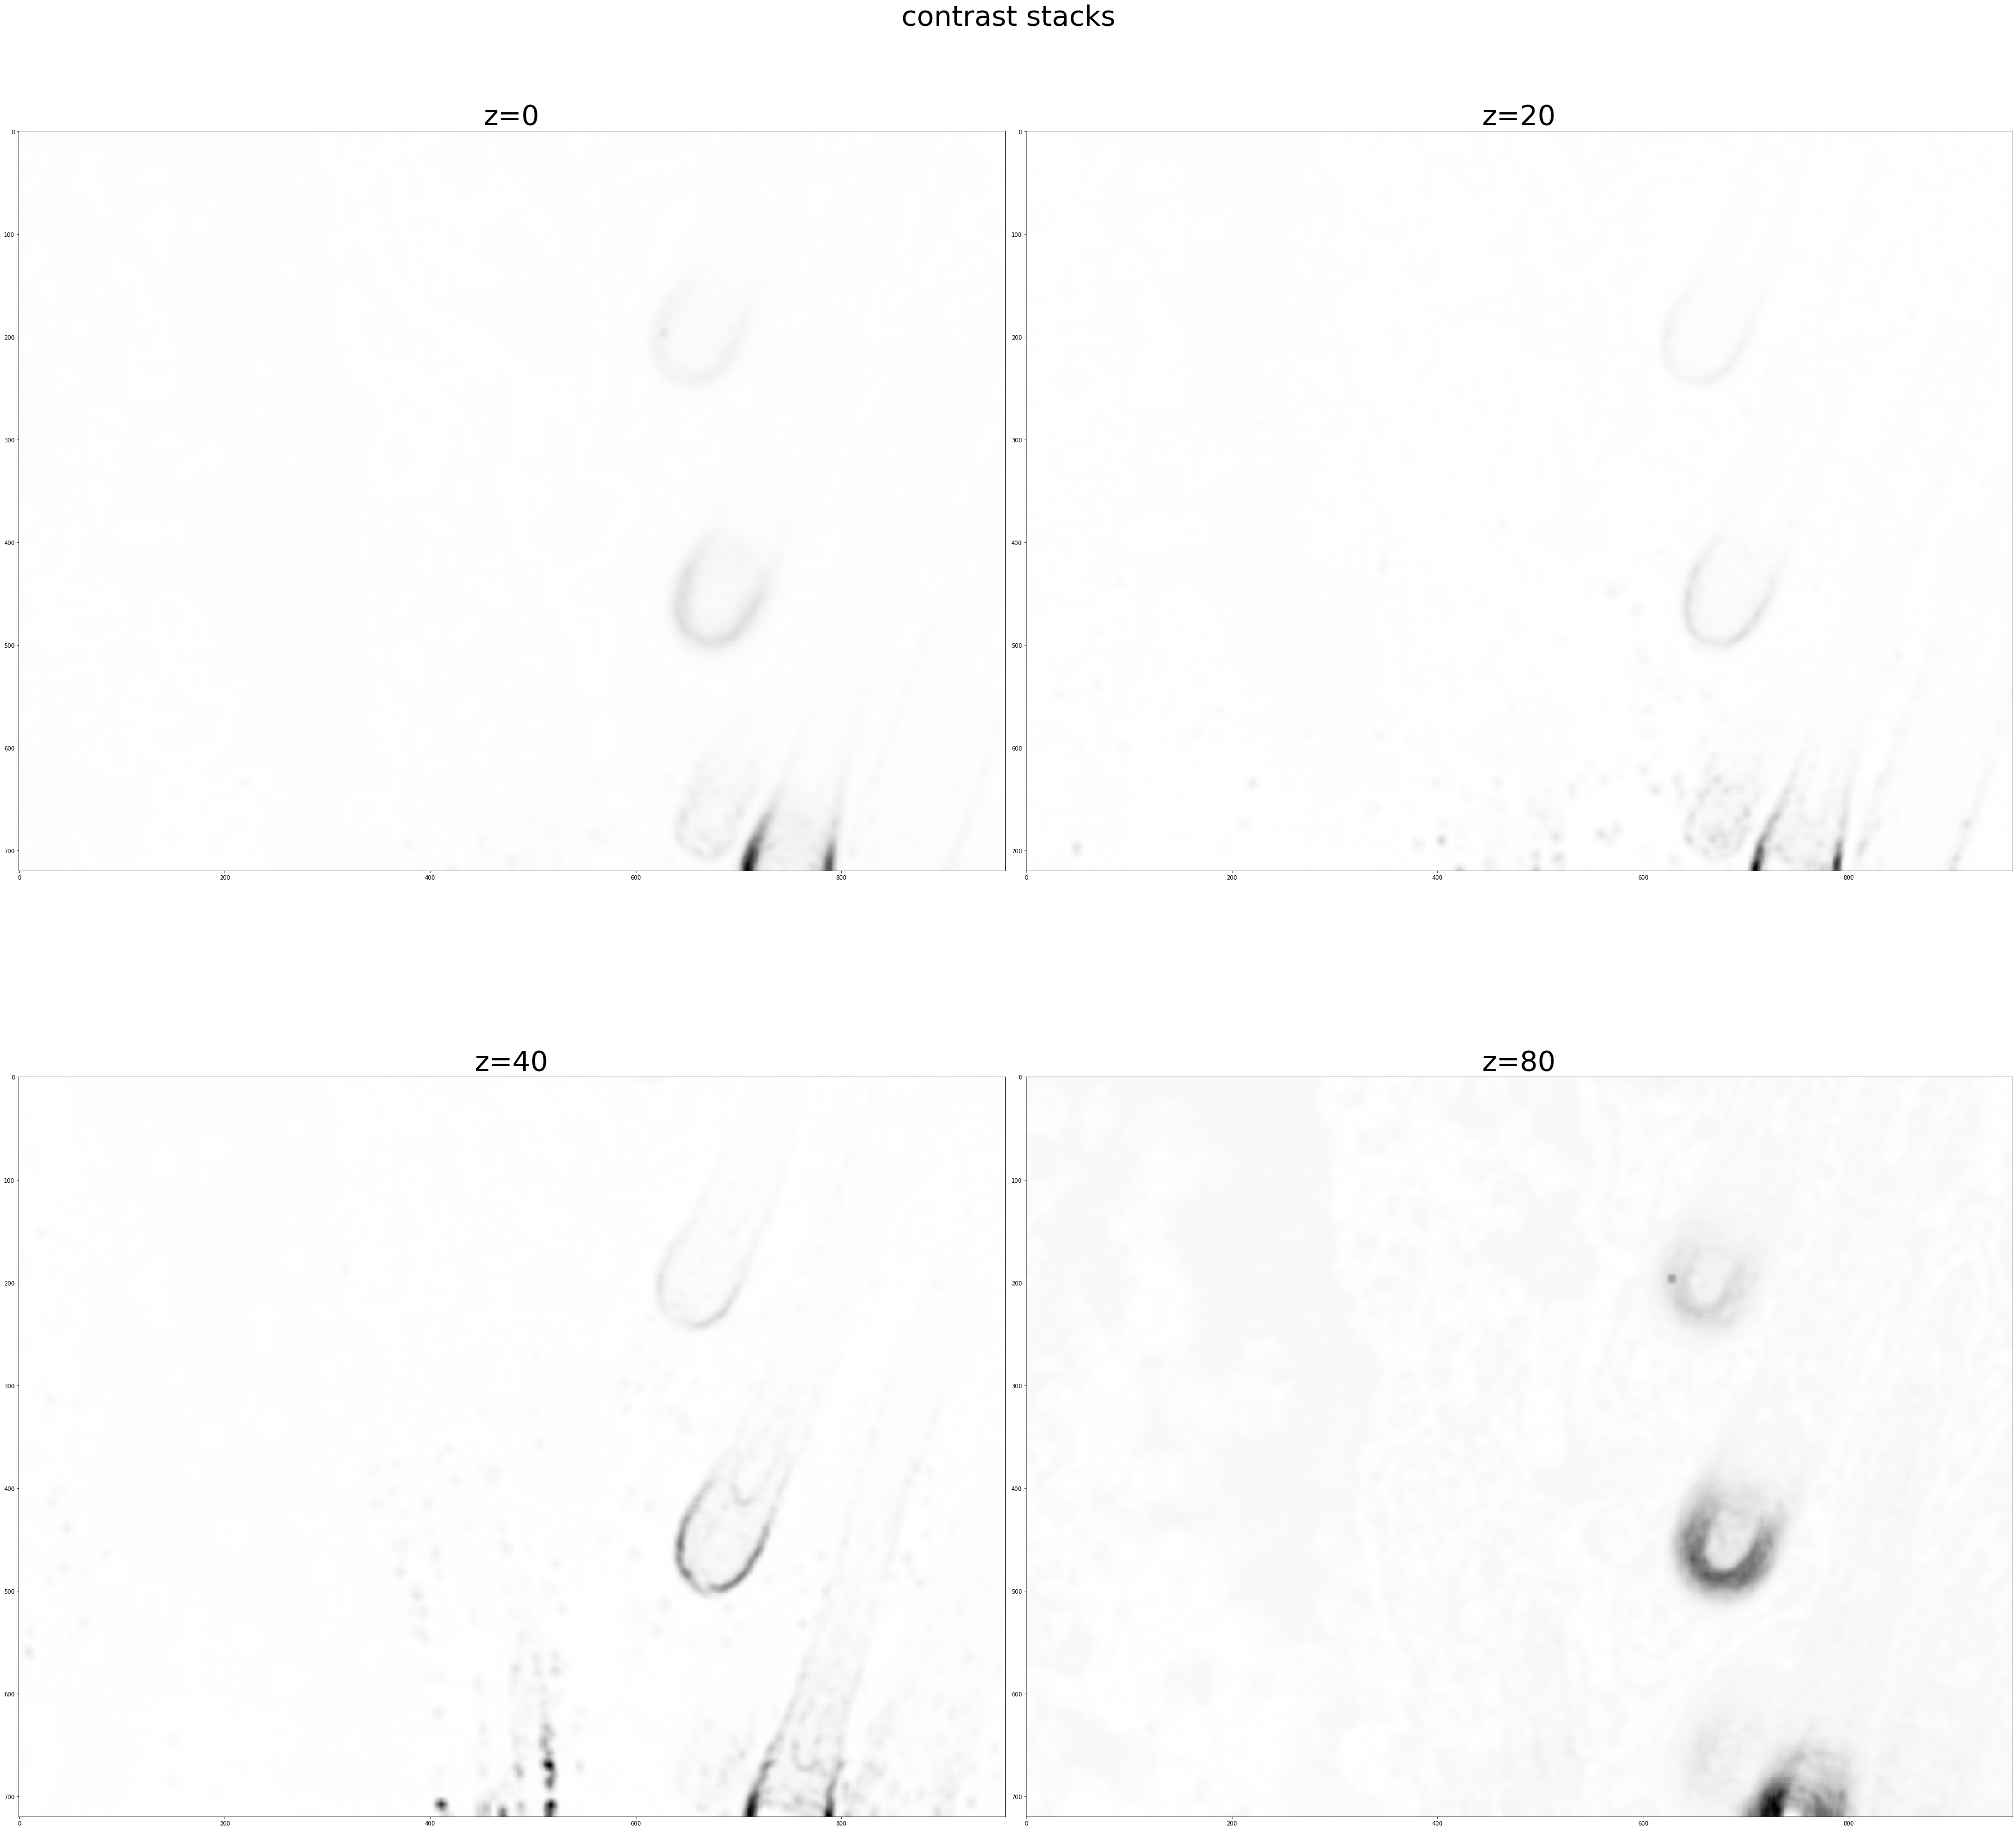

In [437]:
print(cstacks[0].shape,len(cstacks))

fig = plt.figure(figsize=(50,50))
fig.set_tight_layout(True)
fig.suptitle('contrast stacks',fontsize=50)
ax = fig.add_subplot(2,2,1)
ax.imshow(cstacks[0],cmap='Greys')
ax.set_title('z=0',fontsize=50)
ax = fig.add_subplot(2,2,2)
ax.imshow(cstacks[20],cmap='Greys')
ax.set_title('z=20',fontsize=50)
ax = fig.add_subplot(2,2,3)
ax.imshow(cstacks[40],cmap='Greys')
ax.set_title('z=40',fontsize=50)
ax = fig.add_subplot(2,2,4)
ax.imshow(cstacks[80],cmap='Greys')
ax.set_title('z=80',fontsize=50)

float64


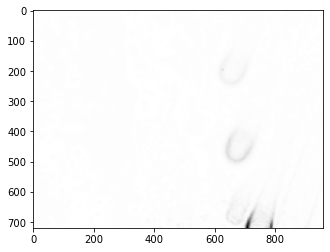

In [438]:
foo = np.array(cstacks) #turn contrast stacks into an array and sort along z at each element for highest layer index
foo.shape
print(foo.dtype)
plt.imshow(foo[0,:,:],cmap='Greys')

In [439]:
max_cstacks = np.argmax(foo,axis=0) #single layer in shape of single input image with elements representing best z layer index
print(max_cstacks.shape)
print(max_cstacks.dtype, bar.max())
#bar = (max_cstacks//255).astype('uint8')
print(max_cstacks.dtype) #it doesn't matter that this is int64 since it's limited to the number of z layers

(720, 960)
int64 81
int64


int64


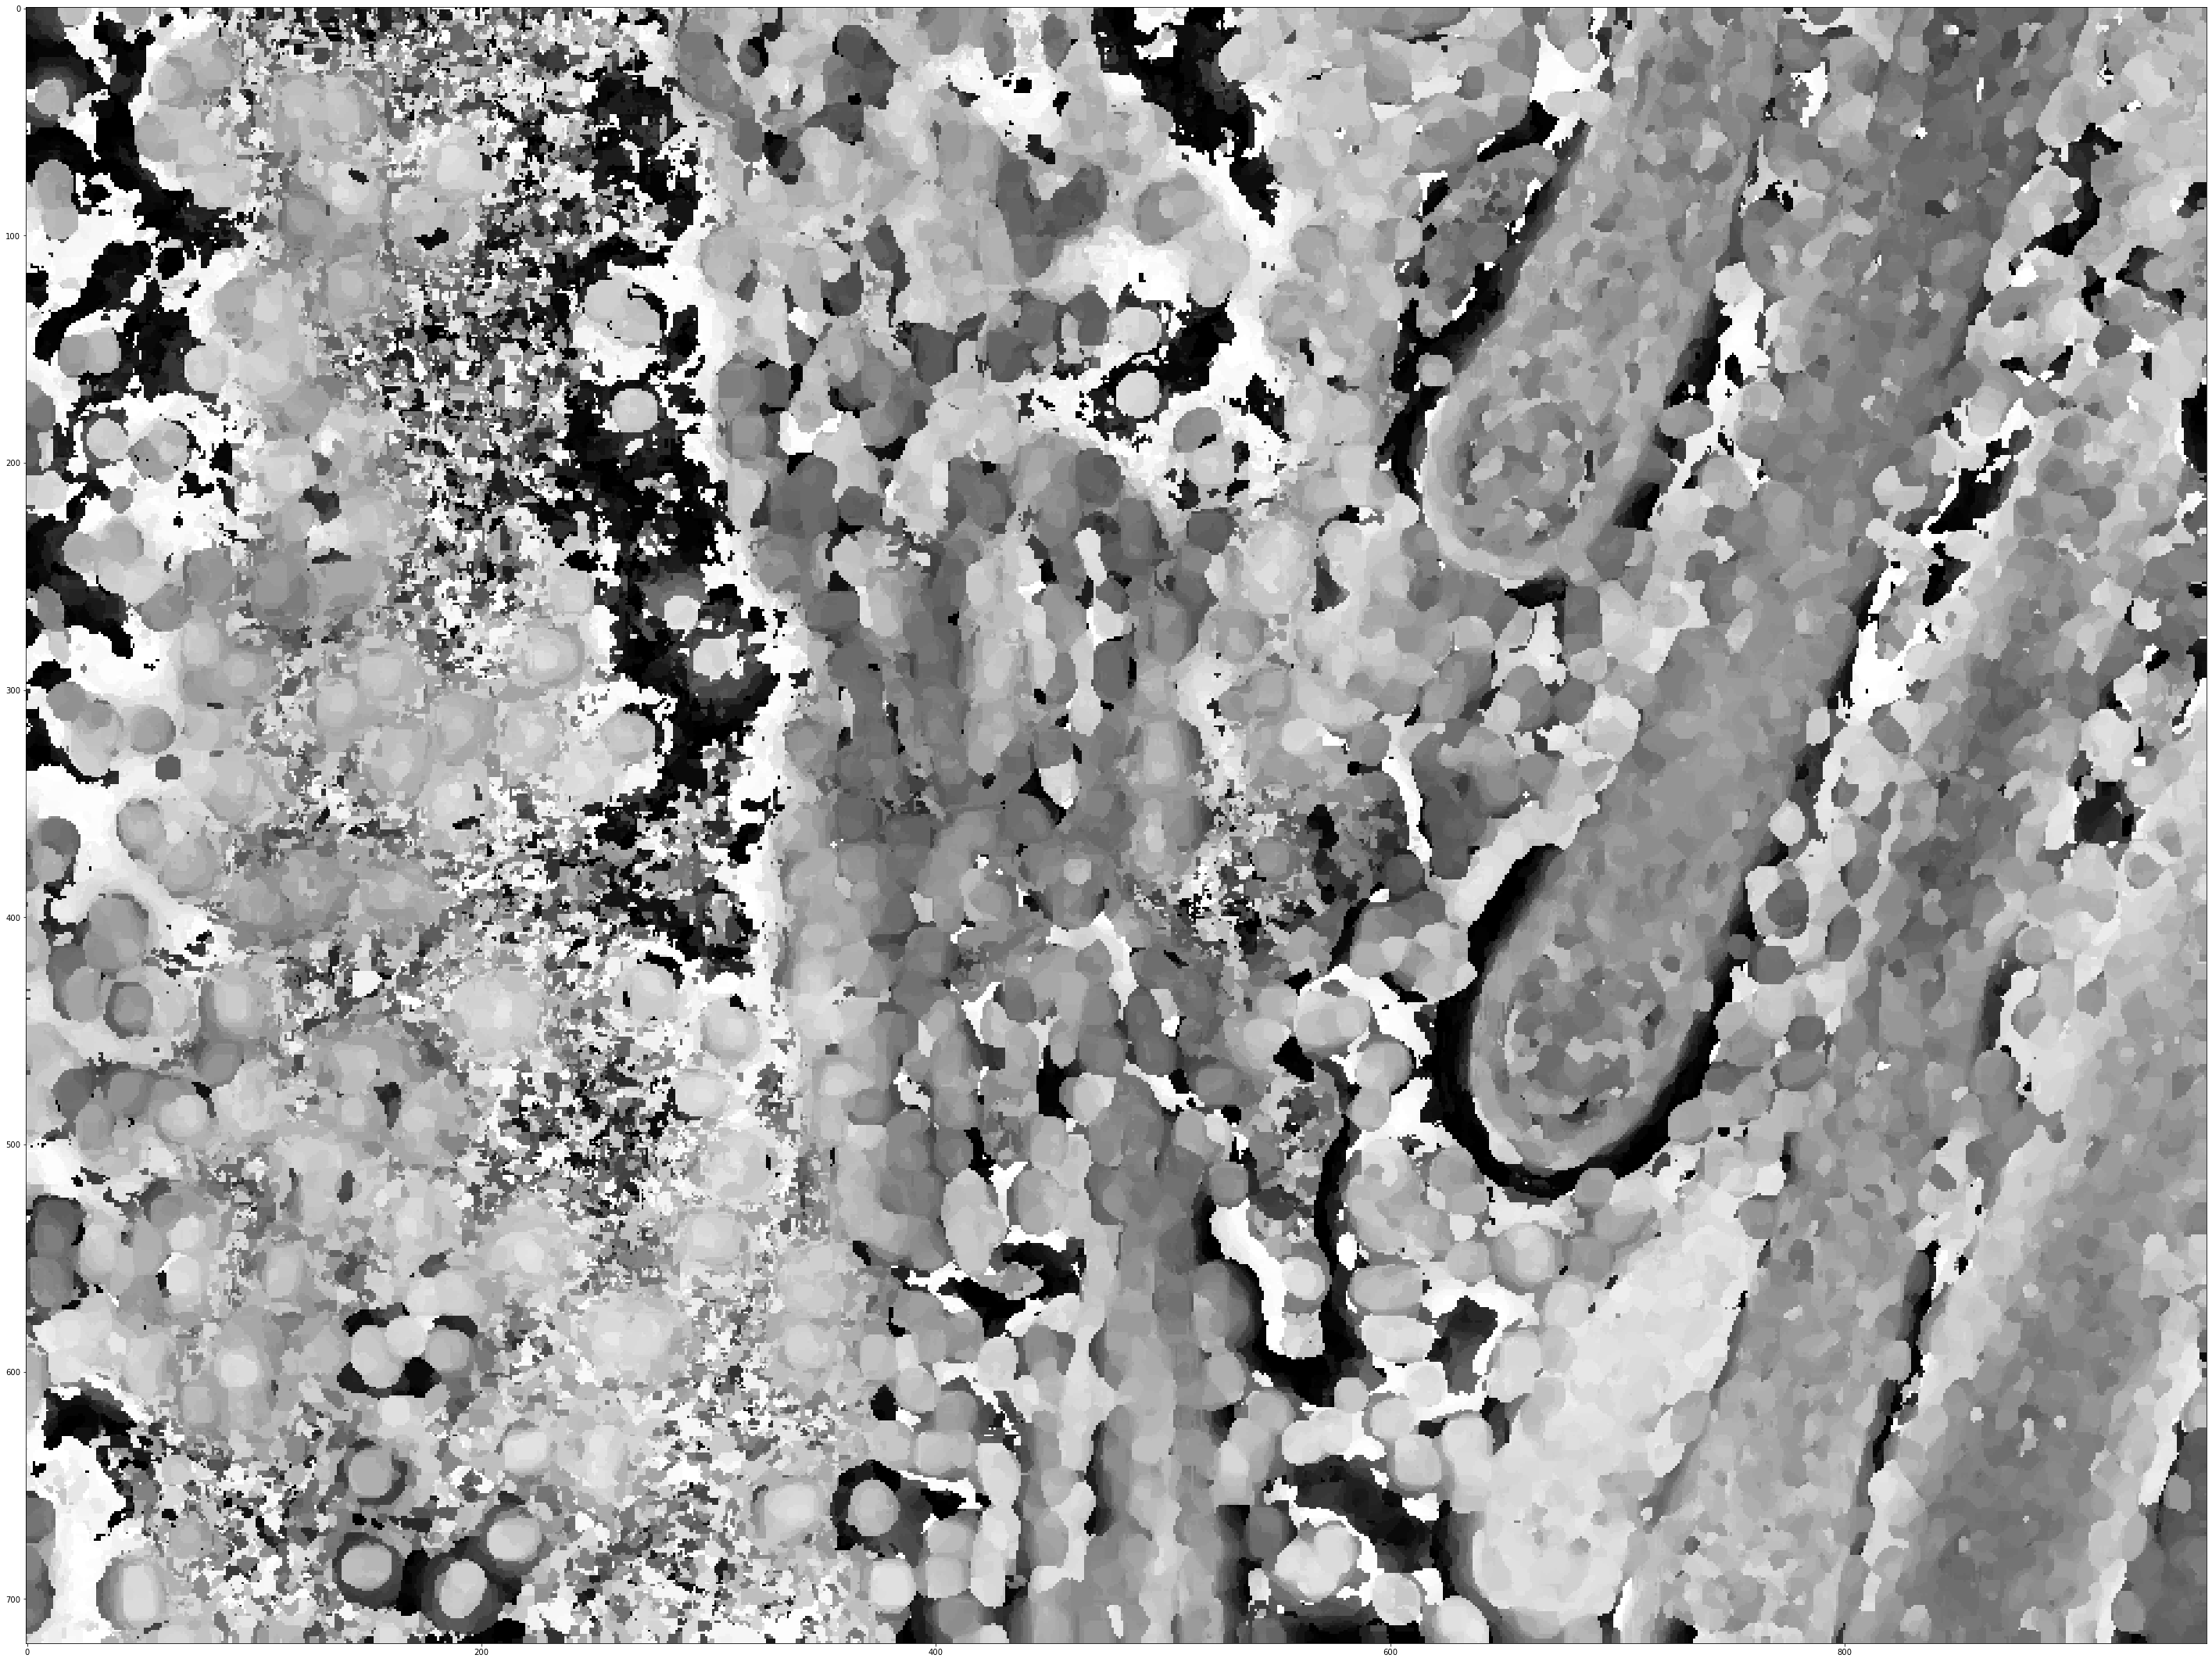

In [440]:
plt.figure(figsize=(50,50))
plt.imshow(max_cstacks,cmap='Greys')
#tifffile.imwrite(str("/Users/wesleywong/max-contrast/art1.tif"),np.uint8(bar))
print(max_cstacks.dtype)

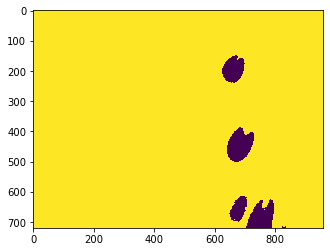

In [451]:
#1-25-21 begin trying to work in this halo reduction code (fixGaussianBlur)

imageStack = image_stack_arrays
indexMap = max_cstacks
blur_size = 3 #dunno just try something

# Use the minimum intensity projection to segment the FG vs BG
proj_min = np.min(imageStack, axis=0) #single channel stack
#otsu_thresh, image_res = cv2.threshold(proj_min, 0,255,cv2.THRESH_OTSU)
ret,otsu_thresh = cv2.threshold(proj_min,127,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
proj_min_bin = proj_min >= otsu_thresh

plt.imshow(proj_min_bin)

bool


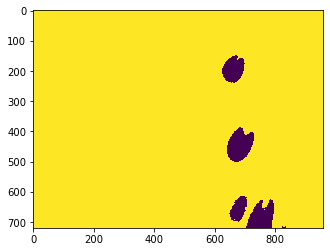

In [452]:

# Fill the small holes in proj_min_bin... or not???
#proj_min_bin = fillHull(proj_min_bin * 1)

#proj_min_bin = ndimage.morphology.binary_fill_holes(proj_min_bin)

#proj_min_bin = ConvexHull(proj_min_bin,interpolation_distance=100)


plt.imshow(proj_min_bin)
print(proj_min_bin.dtype)
proj_min_bin = proj_min_bin.astype('uint8')

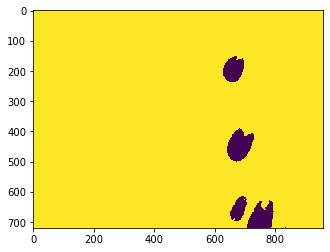

In [453]:
# In order to fix the blur, propagation is only required into the areas 
# immediately surrounding the foreground spots. This has the advantage of 
# not affecting potentially dark regions not detected by the thresholding 
# as foreground
#f = makeBrush(size=blur_size*2+1, shape="disc", step=TRUE) #this needs conversion to python
f = np.full((blur_size,blur_size),1)
bin_img_overlay = cv2.filter2D(proj_min_bin ,-1, kernel=f)
bin_img_overlay[bin_img_overlay > 1] = 1

plt.imshow(bin_img_overlay)




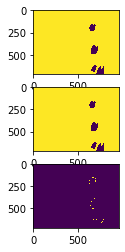

In [454]:
what_is_this = cv2.threshold(bin_img_overlay,-1,126,255,cv2.THRESH_BINARY)[1].astype('uint8') #since thershold returns a tuple


#bin_img_overlay = bin_img_overlay > cv2.threshold(bin_img_overlay,-1,126,255,cv2.THRESH_BINARY)[1].astype('uint8') #since thershold returns a tuple
#expand_region = bin_img_overlay * (1-proj_min_bin)
expand_region = what_is_this * (1-proj_min_bin)

fig,ax = plt.subplots(3,1)
plt.subplot(3,1,1)
plt.imshow(what_is_this)

plt.subplot(3,1,2)
plt.imshow(bin_img_overlay)

plt.subplot(3,1,3)
plt.imshow(expand_region)

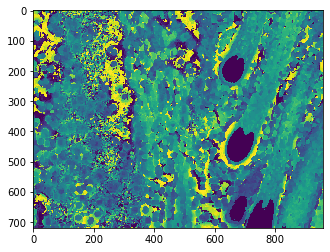

In [455]:
# Define the seed map, i.e. the regions from which to propagate
seed_map = indexMap * proj_min_bin

plt.imshow(seed_map)


In [456]:


seed_coord = []
for row in range(seed_map.shape[0]):
    for col in range(seed_map.shape[1]):
        if seed_map[row,col] > 80:
            seed_coord.append((col,row))

In [457]:
seed_coord

[(479, 0),
 (480, 0),
 (481, 0),
 (482, 0),
 (483, 0),
 (512, 0),
 (514, 0),
 (515, 0),
 (516, 0),
 (517, 0),
 (518, 0),
 (519, 0),
 (520, 0),
 (521, 0),
 (522, 0),
 (523, 0),
 (524, 0),
 (525, 0),
 (526, 0),
 (527, 0),
 (248, 1),
 (276, 1),
 (277, 1),
 (479, 1),
 (480, 1),
 (481, 1),
 (482, 1),
 (483, 1),
 (512, 1),
 (513, 1),
 (514, 1),
 (515, 1),
 (516, 1),
 (517, 1),
 (518, 1),
 (519, 1),
 (520, 1),
 (521, 1),
 (522, 1),
 (523, 1),
 (524, 1),
 (525, 1),
 (526, 1),
 (527, 1),
 (248, 2),
 (274, 2),
 (275, 2),
 (276, 2),
 (479, 2),
 (480, 2),
 (481, 2),
 (482, 2),
 (483, 2),
 (511, 2),
 (512, 2),
 (513, 2),
 (514, 2),
 (515, 2),
 (516, 2),
 (517, 2),
 (518, 2),
 (519, 2),
 (520, 2),
 (521, 2),
 (522, 2),
 (523, 2),
 (524, 2),
 (525, 2),
 (526, 2),
 (527, 2),
 (248, 3),
 (274, 3),
 (275, 3),
 (276, 3),
 (277, 3),
 (479, 3),
 (480, 3),
 (481, 3),
 (482, 3),
 (483, 3),
 (511, 3),
 (512, 3),
 (513, 3),
 (514, 3),
 (515, 3),
 (516, 3),
 (517, 3),
 (518, 3),
 (519, 3),
 (520, 3),
 (521, 3),

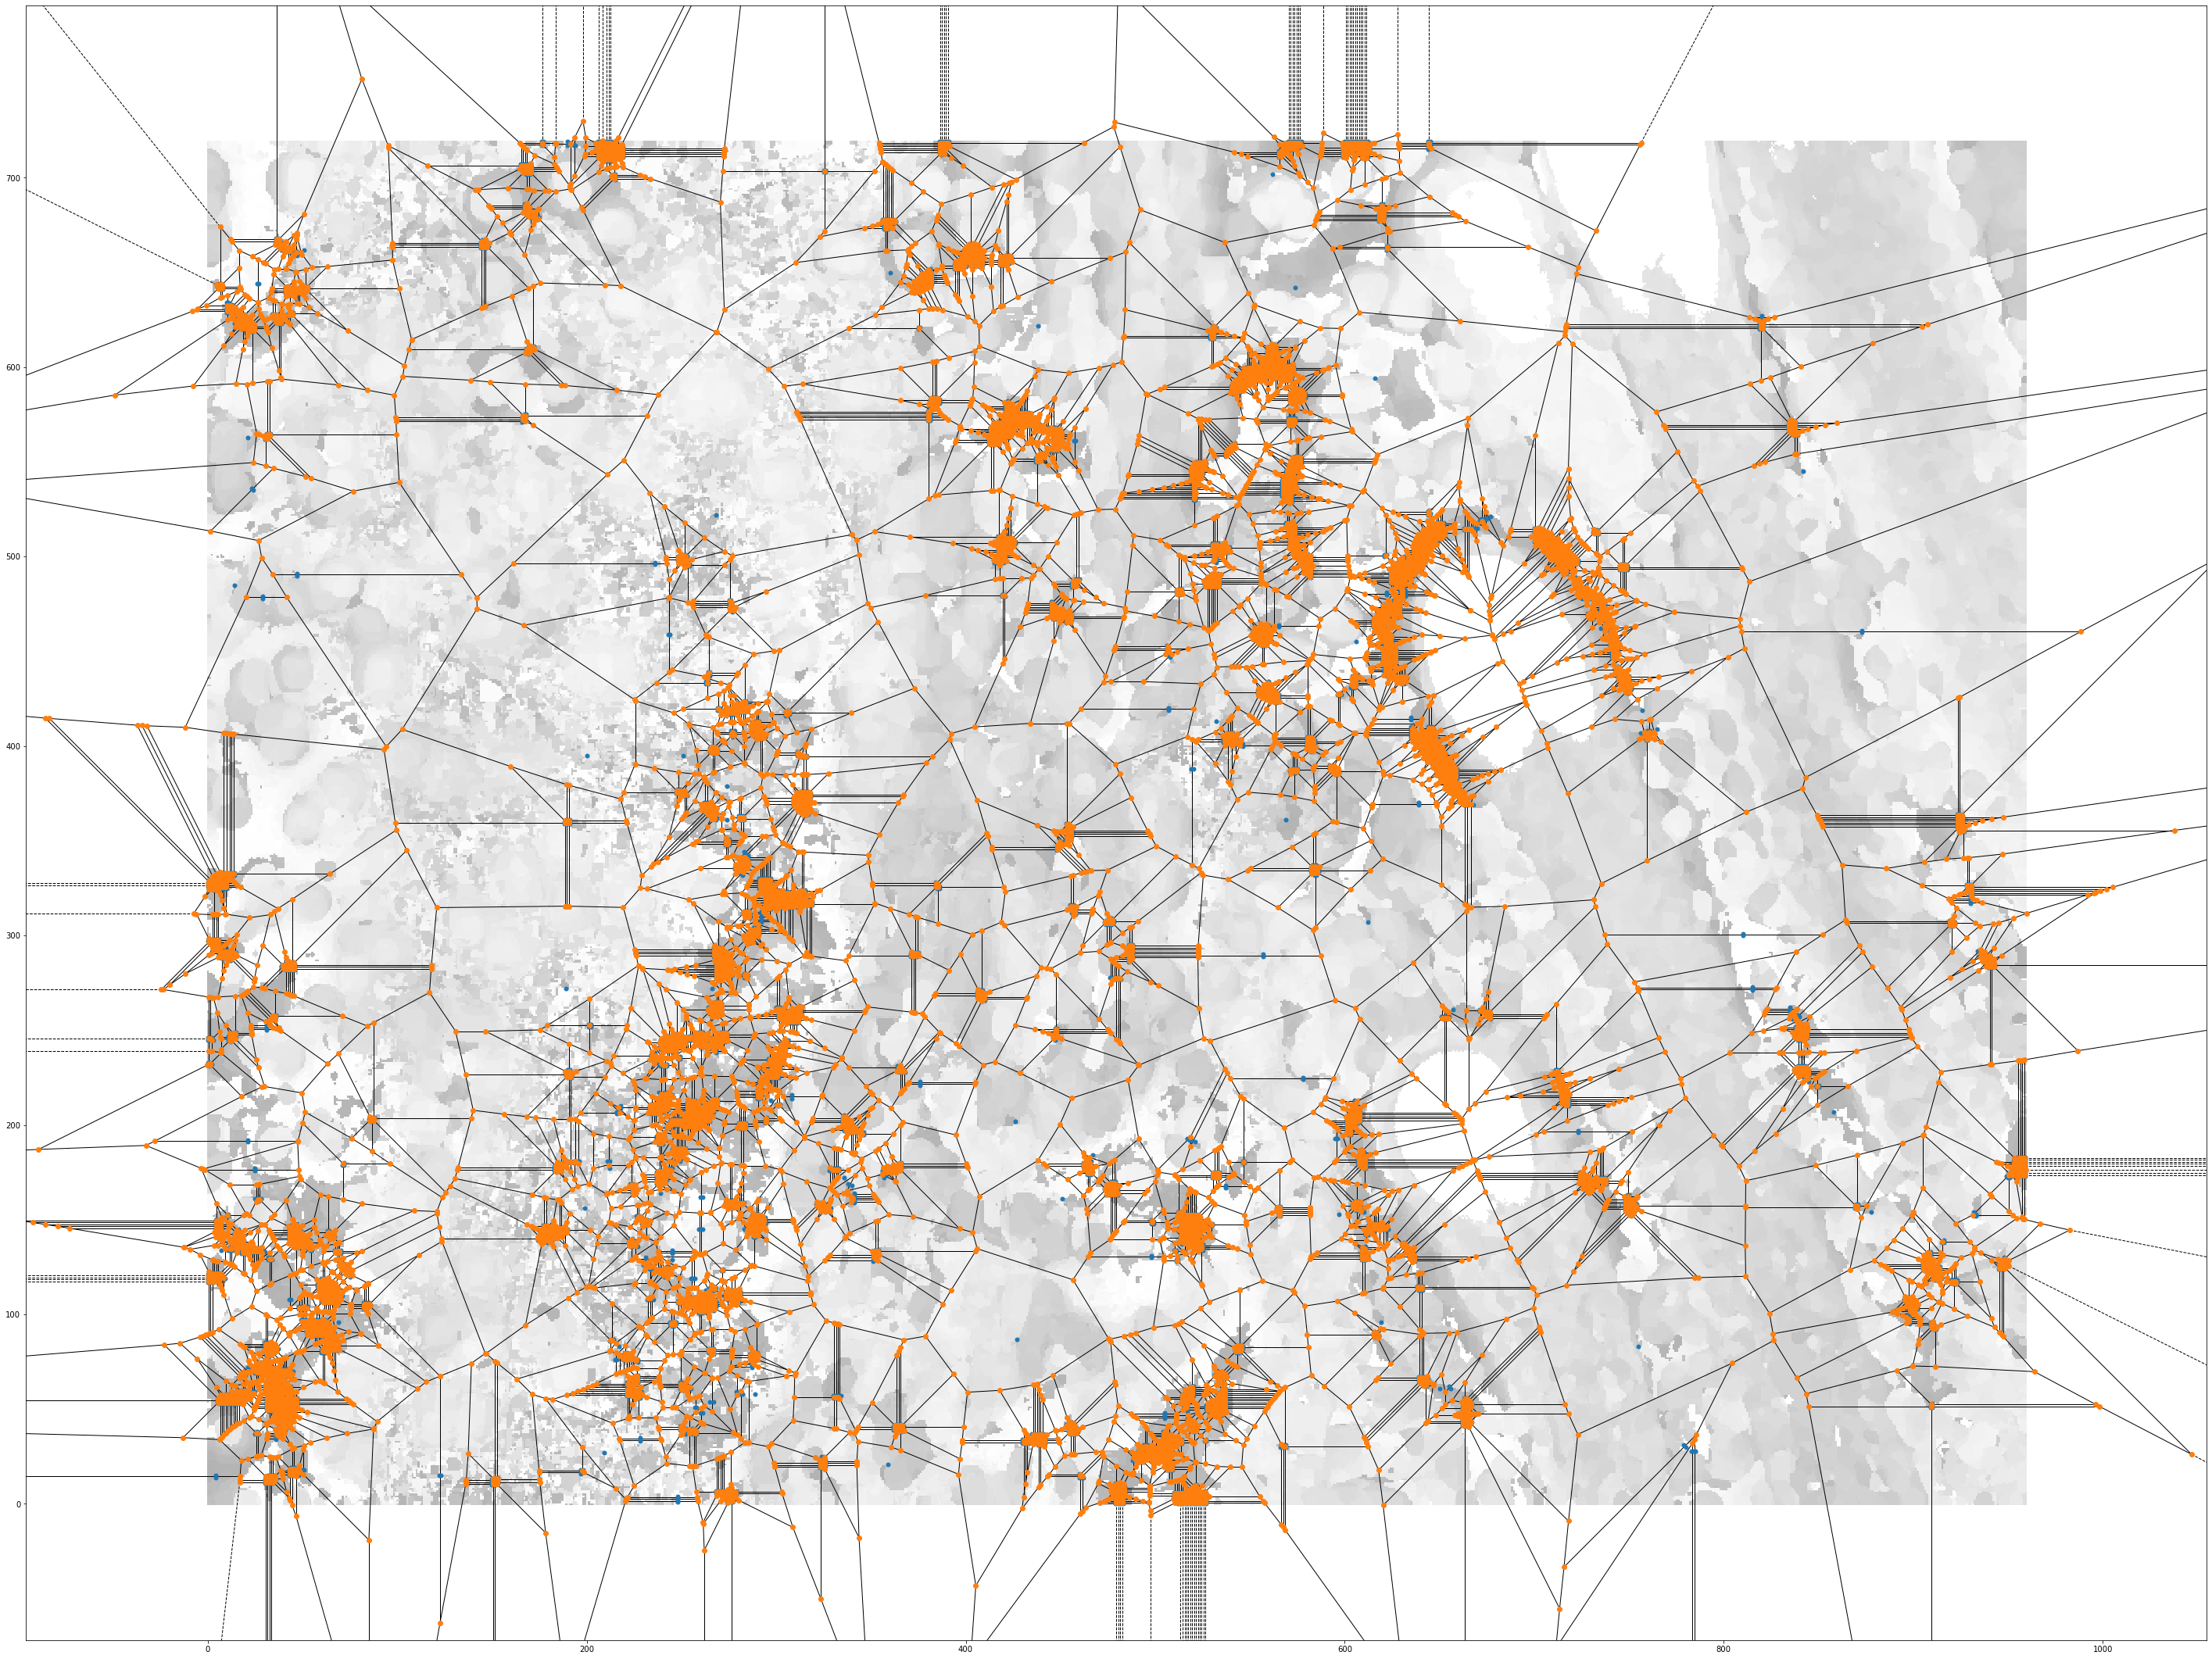

In [458]:

# lambda is a mixing parameter between the euclidean distance and the 
# gradient of 'x' in 'EBImage::propagate()' when calculating the distance 
# 'd' between two points. According to the documentation of this function, 
# as lambda goes to infinity, 'd' tends to the euclidean distance, so a 
# sufficiently large value of lambda should be used here.

plt.figure(figsize=(50,50))
ax = plt.axes()
indexMap_adjusted = Voronoi(seed_coord, furthest_site=False)
fig = voronoi_plot_2d(indexMap_adjusted,ax,show_points=True, show_vertices=True, line_width=1,point_size=10)
ax.imshow(seed_map,cmap="Greys",alpha=0.3)
plt.show()


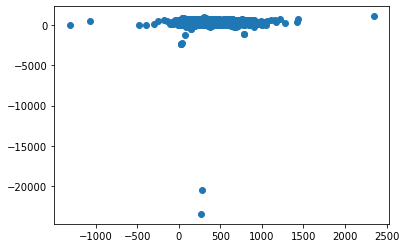

In [459]:
scatter_x = [(e[0]) for e in indexMap_adjusted.vertices]
scatter_y = [(e[1]) for e in indexMap_adjusted.vertices]
plt.scatter(scatter_x,scatter_y)
plt.show()

In [460]:
type(indexMap_adjusted)

scipy.spatial.qhull.Voronoi

indexMap shape (720, 960)
indexMap_adjusted.vertices shape (13895, 2)


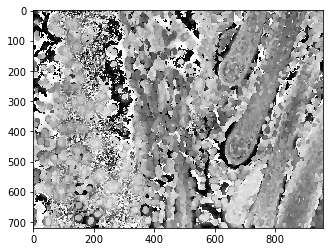

In [461]:
# The true index map is now the combination of the original index map plus 
# the propagated values in the expand regions
true_index_map = indexMap
print('indexMap shape %s' % str(indexMap.shape))
print('indexMap_adjusted.vertices shape %s' % str(indexMap_adjusted.vertices.shape))

adj = indexMap_adjusted.points
adj.max()
adj_dst = np.full((720,960),0)
for el in adj:
    adj_dst[el[1].astype('int'), el[0].astype('int')] = 1
    
plt.imshow(adj,cmap="seismic")    
plt.imshow(true_index_map,cmap="Greys")

true_index_map[expand_region == 1] = adj_dst[expand_region == 1]

int64


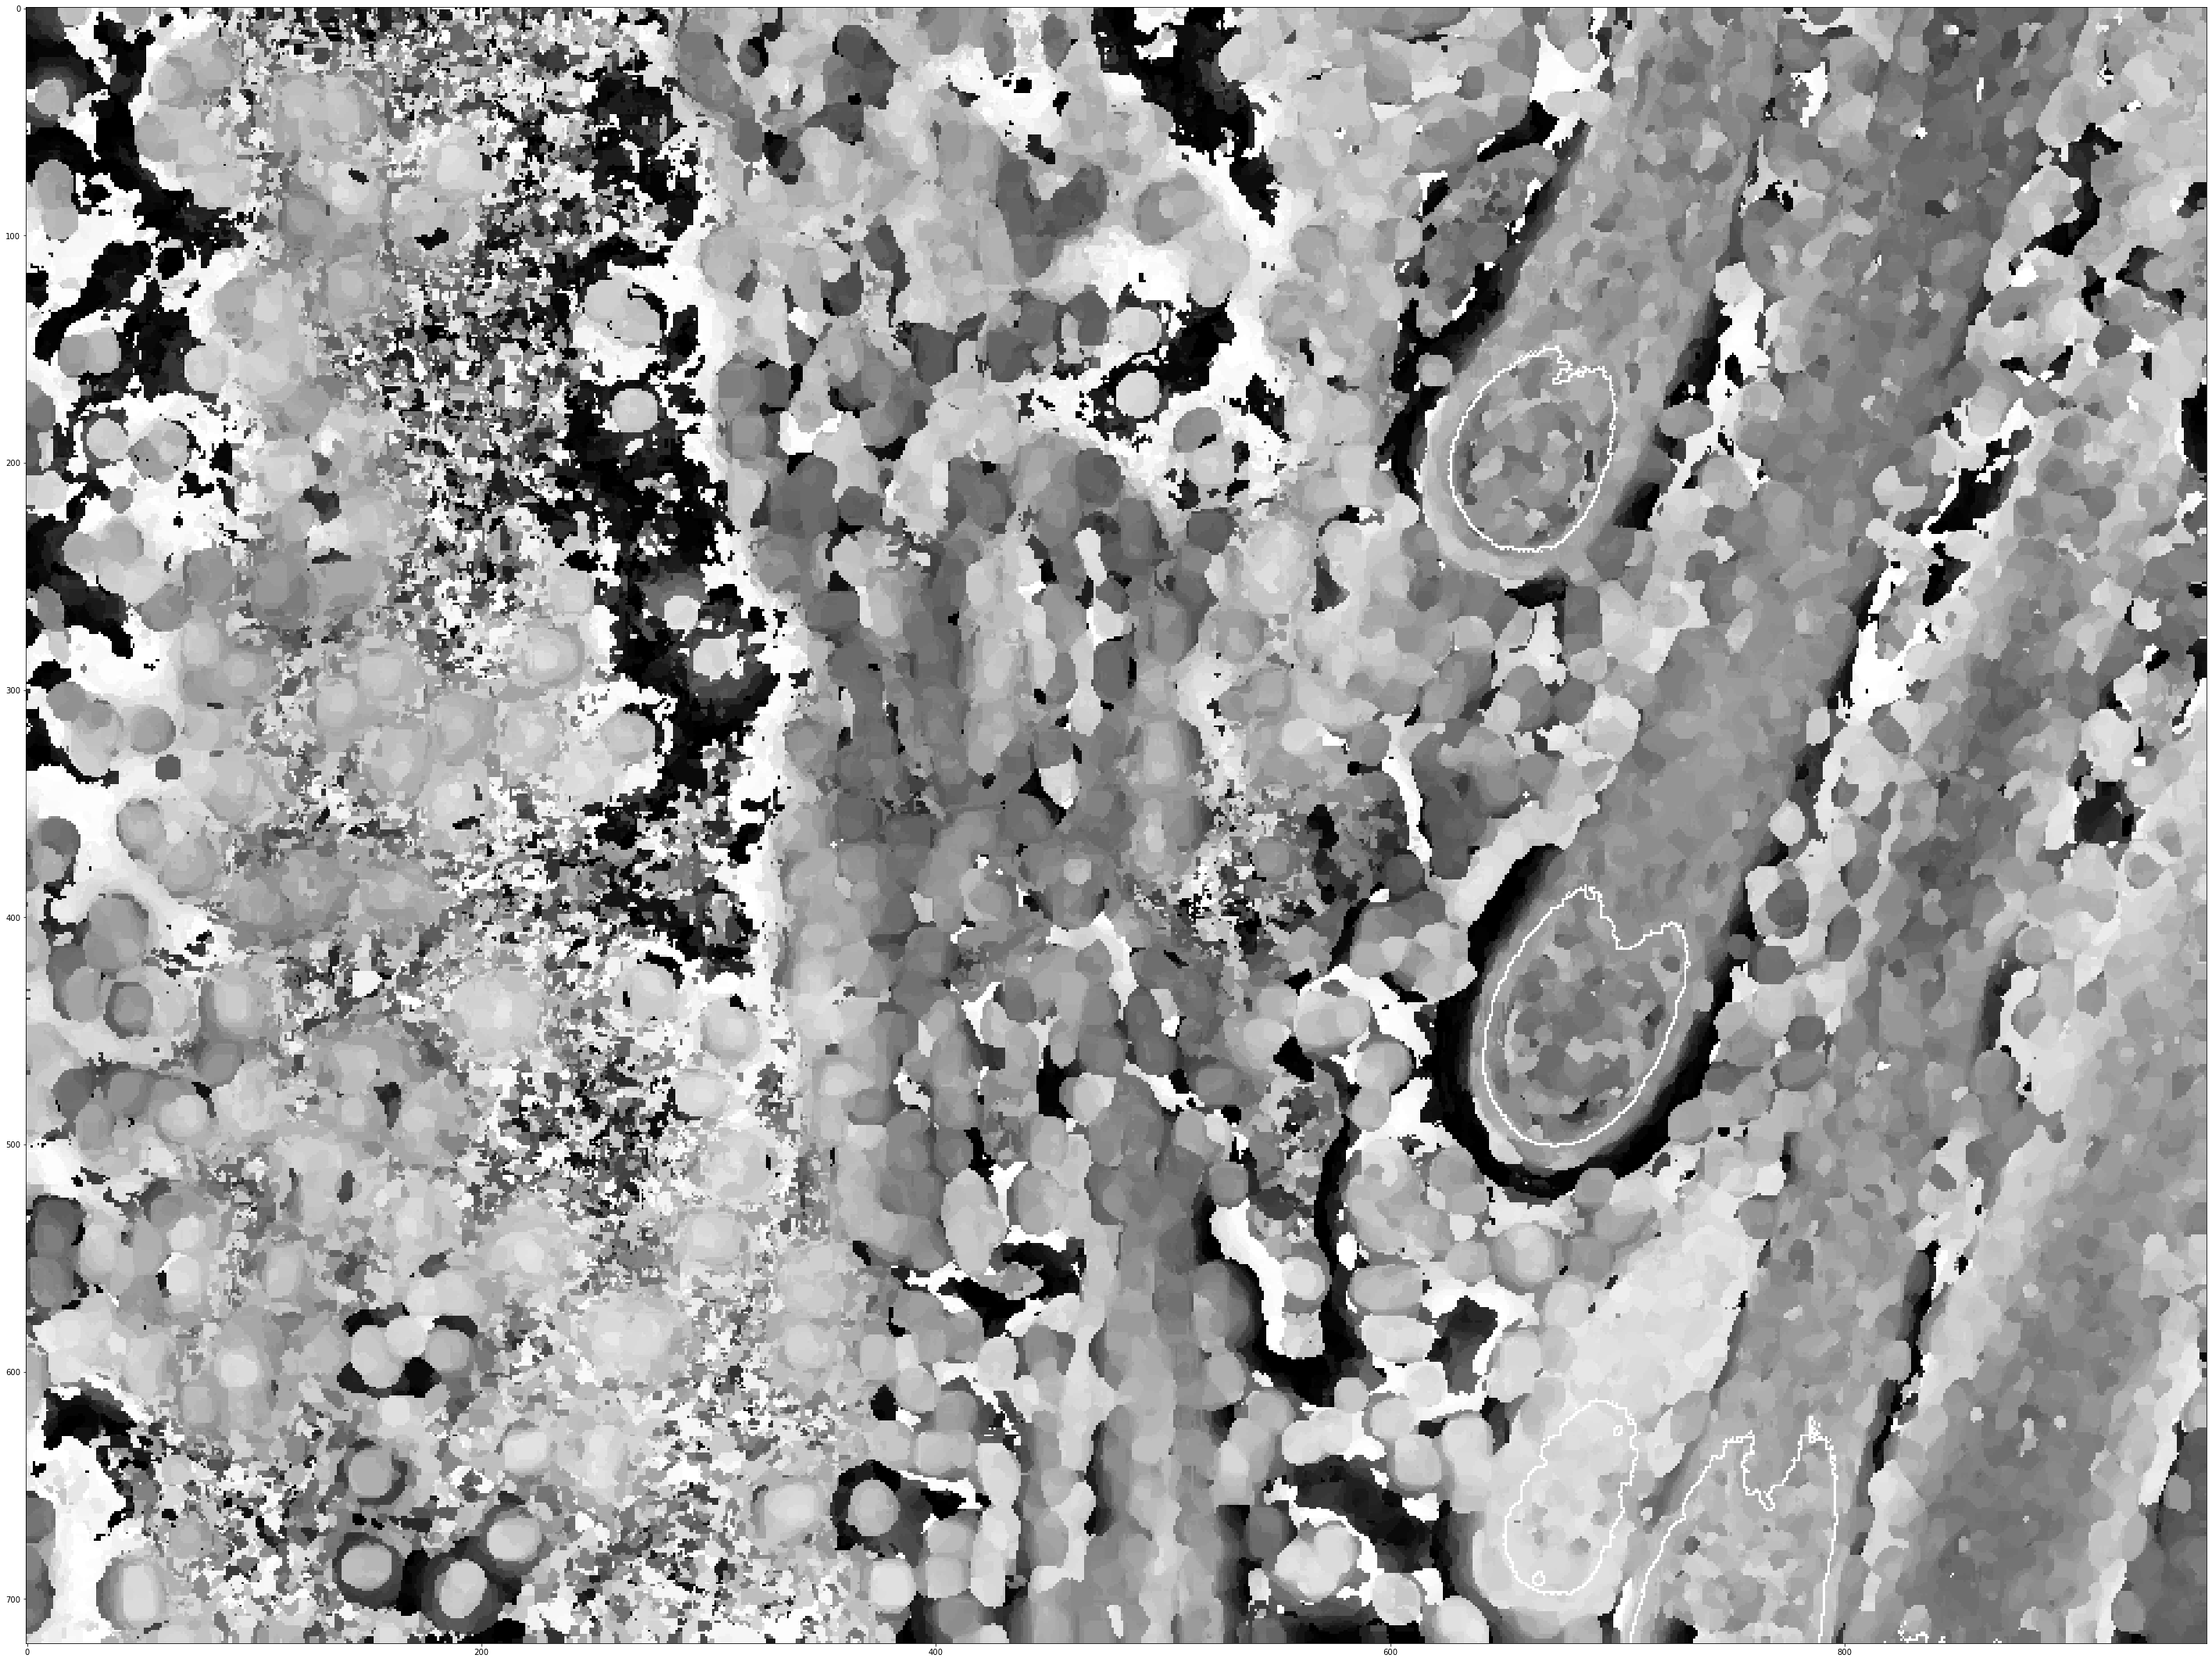

In [462]:
plt.figure(figsize=(50,50))
plt.imshow(true_index_map,cmap="Greys")
print(true_index_map.dtype)

int64


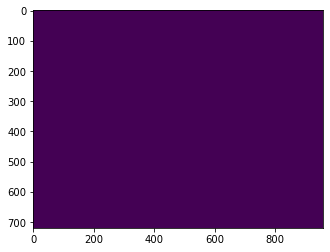

In [466]:
plt.imshow(max_cstacks-true_index_map)
print(max_cstacks.dtype)

In [401]:
proj = np.full(bar.shape, 0)
for row in range(bar.shape[0]):
    for col in range(bar.shape[1]):
        proj[row,col] = image_stack_arrays[bar[row,col]][row,col]
print(proj.dtype,proj.max())
proj=np.uint8(proj)

int64 76


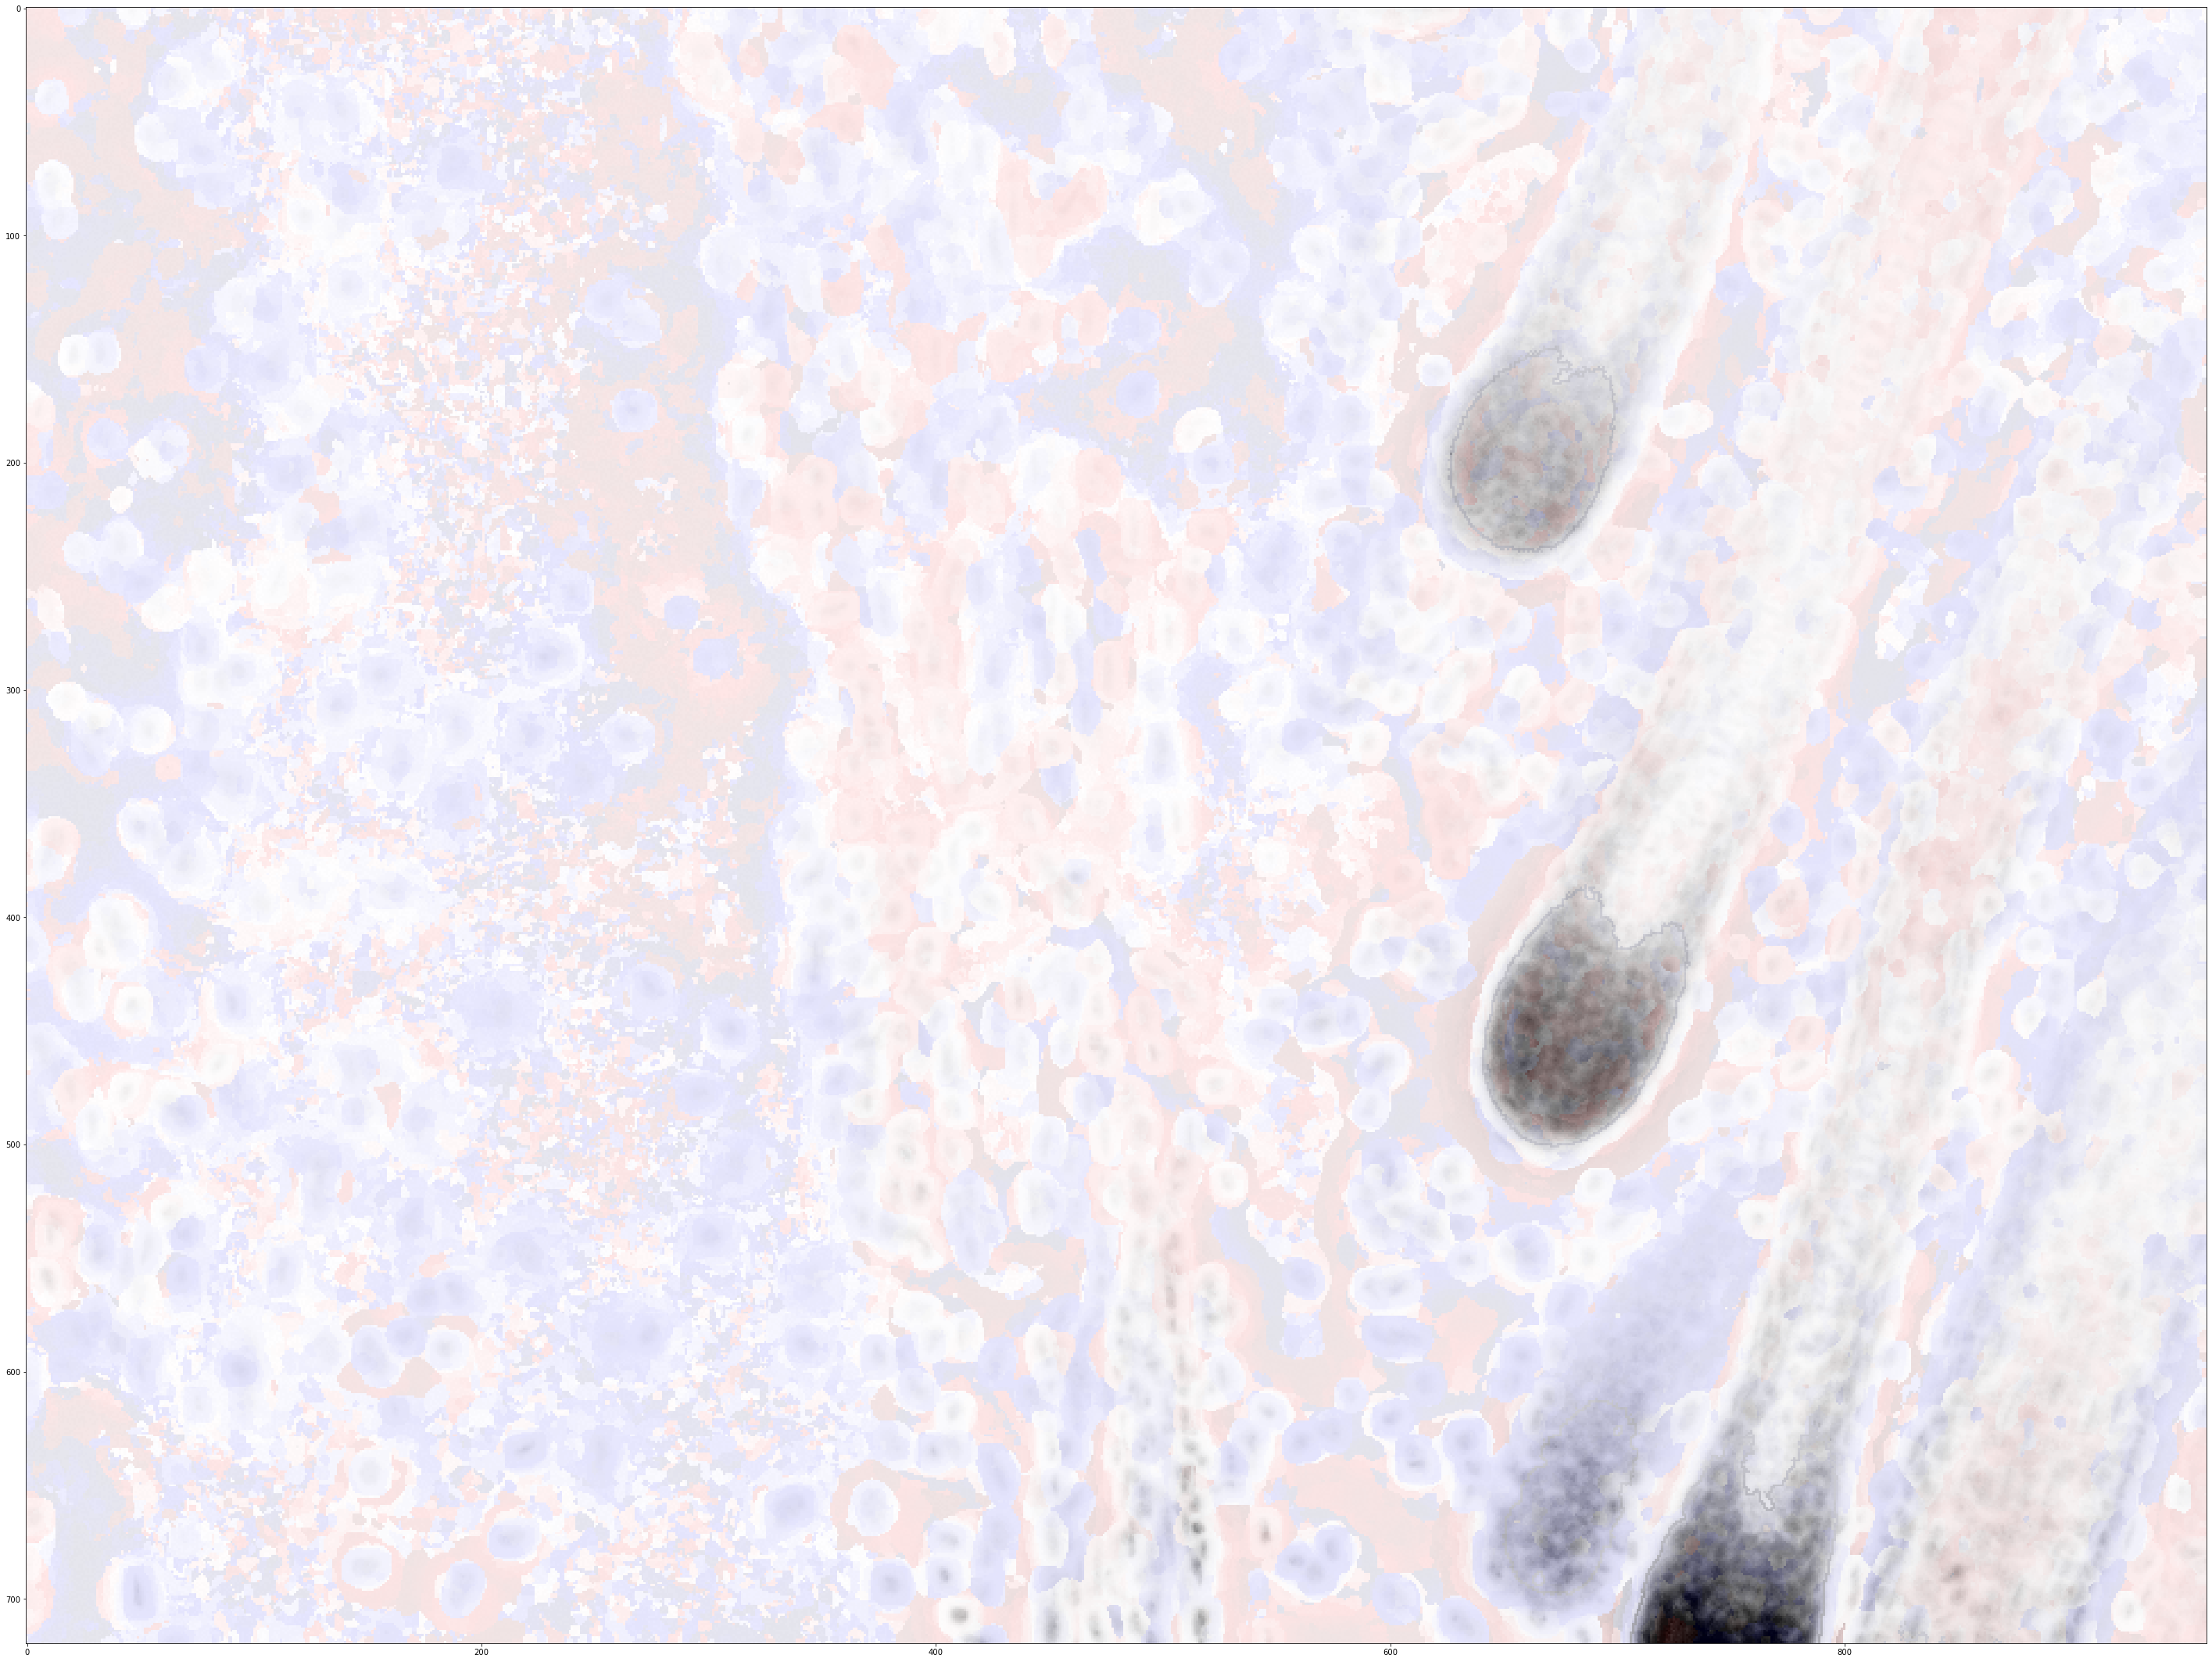

In [470]:
plt.figure(figsize=(50,50))
plt.imshow(proj,cmap='Greys') #max contrast projection?????
plt.imshow(true_index_map,alpha=.1,cmap="seismic")
#tifffile.imwrite(str("/Users/wesleywong/max-contrast/K%s_S%s_output.tif" % (str((var_kernel_row,var_kernel_col)), str(cstacks_blur_kernel))),proj)


(720, 960)


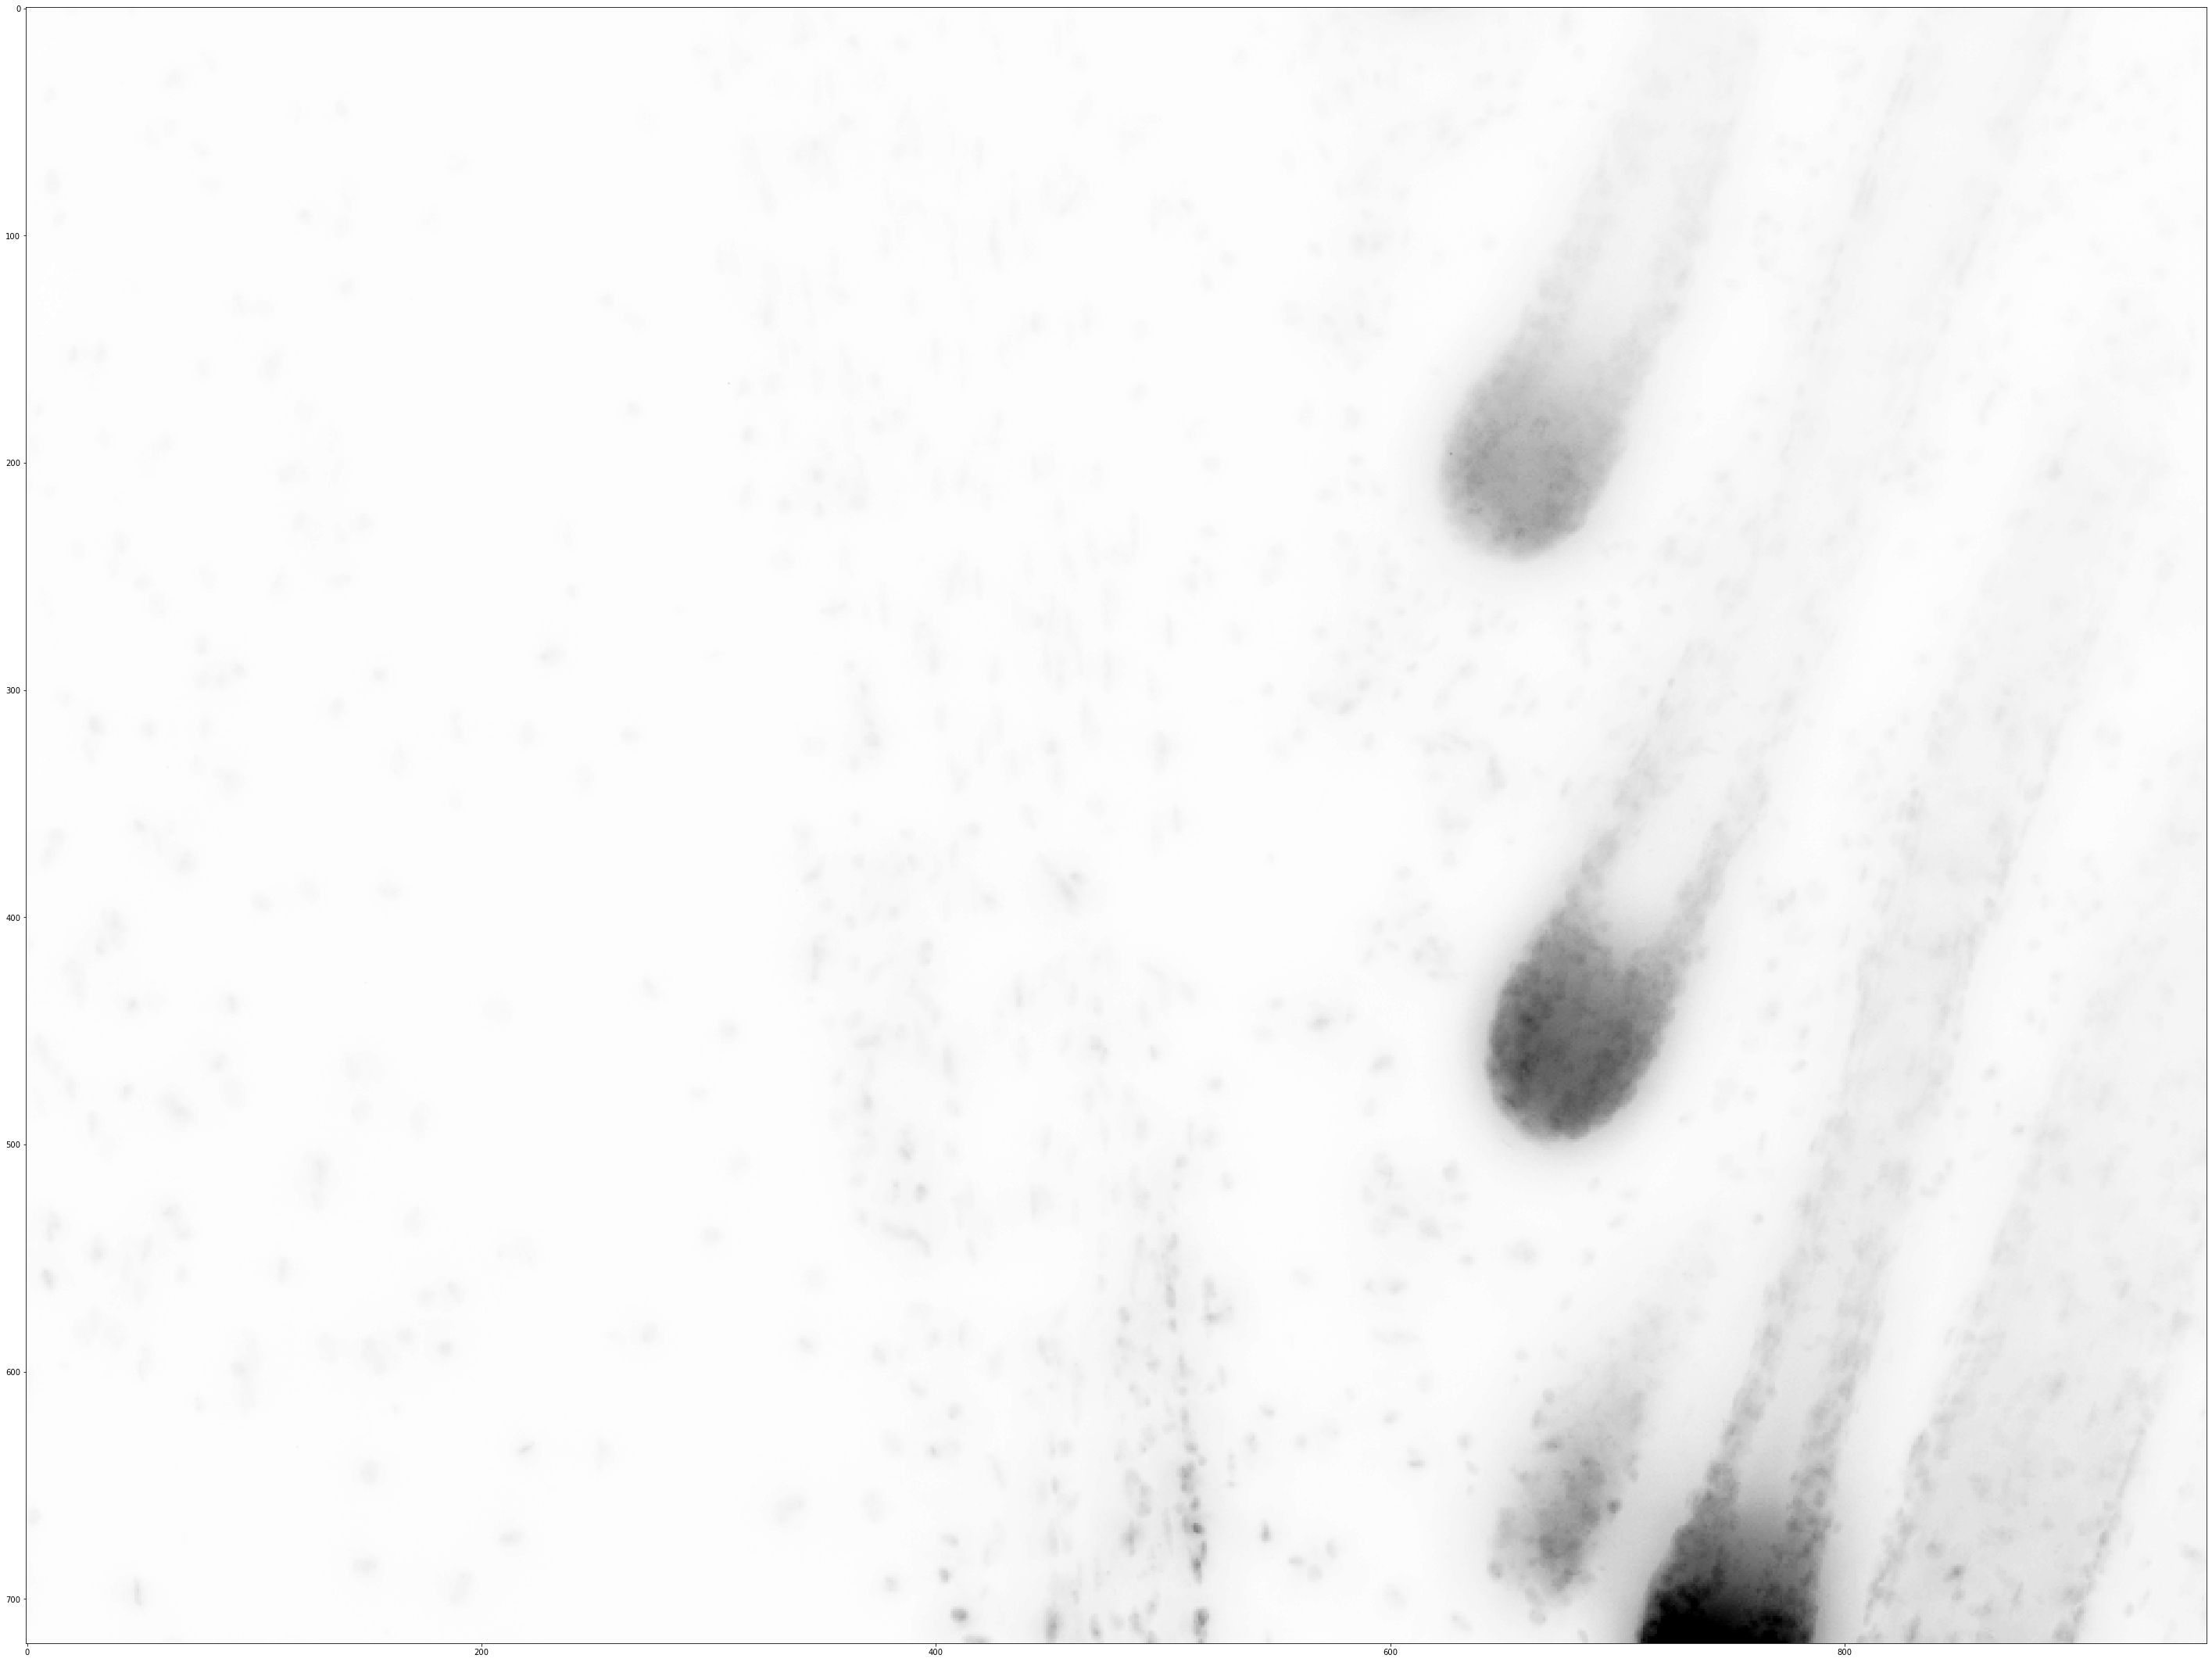

In [403]:
plt.figure(figsize=(50,50))
intensity_projected = np.max(image_stack_arrays,axis=0)
print(intensity_projected.shape)
plt.imshow(intensity_projected,cmap='Greys') #the original
